In [1]:
%matplotlib notebook

In [2]:
import requests
import json

from census import Census
from us import states

from config import apikey
from config import gkey

import gmaps
gmaps.configure(api_key=gkey)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import geopandas as gpd
import folium
import time

In [3]:
#API calls census using wrapper
c = Census(apikey, year=2017)
census_data = c.acs5.get(("B01003_001E","B01002_001E"),{'for': 'county:*', 'in': 'state:*' })

#converting to dataFrame
census_pd = pd.DataFrame(census_data)

#Renaming the columns
census_pd=census_pd.rename(columns={"B01003_001E":"Total Population","B01002_001E":"Median Age","state":"fips"})

#extracting state population from census data

Population=census_pd.groupby('fips')['Total Population'].sum()
final_fips=census_pd.groupby('fips')['fips'].first()

state_population=pd.DataFrame({"Total Population":Population,"State Fips":final_fips})
state_population.loc[:,'State Fips']=state_population["State Fips"].astype('int64')

In [4]:
zip_path="Resources/state_fips_master.csv"
zip_df=pd.read_csv(zip_path)
zip_df=zip_df.rename(columns={"fips":"State Fips"})

#Merging the census_pd with state_zip_df to obtain state_name column in Census dataFrame
Census_df=pd.merge(state_population,zip_df,on="State Fips")
Census_df=Census_df.rename(columns={"State Fips":"fips","state_name":"State Name"})
print(f"->Total population of US is:{(Census_df['Total Population']).sum()}")
Census_df.head()

->Total population of US is:320332016.0


,Total Population,fips,State Name,state_abbr,long_name,sumlev,region,division,state,region_name,division_name
0,4850771.0,1,Alabama,AL,Alabama AL,40,3,6,1,South,East South Central
1,738565.0,2,Alaska,AK,Alaska AK,40,4,9,2,West,Pacific
2,6809946.0,4,Arizona,AZ,Arizona AZ,40,4,8,4,West,Mountain
3,2977944.0,5,Arkansas,AR,Arkansas AR,40,3,7,5,South,West South Central
4,38982847.0,6,California,CA,California CA,40,4,9,6,West,Pacific


In [5]:
csv_path = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv"

# Read the CSV into a Pandas DataFrame
covid_df = pd.read_csv(csv_path)

In [6]:
#Covid-19 Data on County level

#extracting latest information from the live data
cases_covid=covid_df.groupby(['fips','county','state'])['cases'].last()
deaths_covid=covid_df.groupby(['fips','county','state'])['deaths'].last()
date_covid=covid_df.groupby(['fips','county','state'])['date'].last()
fips_covid=covid_df.groupby(['fips','county','state'])['fips'].first()
state_covid=covid_df.groupby(['fips','county','state'])['state'].first()
county_covid=covid_df.groupby(['fips','county','state'])['county'].first()

#creating new dataframe
County_Covid_df=pd.DataFrame({"Date":date_covid,
                             "County":county_covid,
                             "Total Number of Covid-19 Cases":cases_covid,
                             "Death due to Covid-19":deaths_covid})

In [7]:
state_path = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv"
state_df=pd.read_csv(state_path)
state_df=state_df.rename(columns={'date':'Date','state':'State Name','cases':'Total Covid-19 Cases','deaths':'Total Deaths Covid-19'})
state_df.head()

,Date,State Name,fips,Total Covid-19 Cases,Total Deaths Covid-19
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0


In [8]:
#Covid-19 Data on State Level

cases_state=state_df.groupby(['State Name'])['Total Covid-19 Cases'].sum()
deaths_state=state_df.groupby(['State Name'])['Total Deaths Covid-19'].sum()
date_state=state_df.groupby(['State Name'])['Date'].last()

State_Covid_df=pd.DataFrame({"Date":date_state,"Total Covid-19 Cases":cases_state,"Total Deaths Covid-19":deaths_state})
State_Covid_df=State_Covid_df.reset_index()
State_Covid_df.head()

,State Name,Date,Total Covid-19 Cases,Total Deaths Covid-19
0,Alabama,2020-04-16,49310,1234
1,Alaska,2020-04-16,4422,82
2,American Samoa,2020-04-16,0,0
3,Arizona,2020-04-16,52466,1526
4,Arkansas,2020-04-16,21659,382


In [9]:
#Merging 'Total population per state' with 'covid parameters on state level'
complete_df=pd.merge(State_Covid_df,Census_df,on='State Name')
complete_df=complete_df[["Date","State Name","Total Covid-19 Cases","Total Deaths Covid-19","Total Population","fips"]]

In [10]:
#Adding Latitude and Longitude for HeatMap
latlng_path="Resources/statelatlong.csv"
latlng_df=pd.read_csv(latlng_path)
latlng_df=latlng_df.rename(columns={"City":"State Name"})
HeatMap_df=pd.merge(latlng_df,complete_df,on="State Name")

In [11]:
#Calculating state mortality rate and Case Fatality across states

mortality_df=(HeatMap_df['Total Deaths Covid-19']/HeatMap_df['Total Population'])*100000
Case_fatality=(HeatMap_df['Total Deaths Covid-19']/HeatMap_df['Total Covid-19 Cases']*100)
HeatMap_df['Mortality per 100,000']=mortality_df
HeatMap_df['Case fatality Rate']=Case_fatality
HeatMap_df.head()

,State,Latitude,Longitude,State Name,Date,Total Covid-19 Cases,Total Deaths Covid-19,Total Population,fips,"Mortality per 100,000",Case fatality Rate
0,AL,32.601011,-86.680736,Alabama,2020-04-16,49310,1234,4850771.0,1,25.439255,2.502535
1,AK,61.302501,-158.775020,Alaska,2020-04-16,4422,82,738565.0,2,11.102611,1.854365
2,AZ,34.168219,-111.930907,Arizona,2020-04-16,52466,1526,6809946.0,4,22.408401,2.908550
3,AR,34.751928,-92.131378,Arkansas,2020-04-16,21659,382,2977944.0,5,12.827642,1.763701
4,CA,37.271875,-119.270415,California,2020-04-16,363603,9665,38982847.0,6,24.792956,2.658119


In [12]:
date=time.strftime('%x')
Total_Cases_US=HeatMap_df['Total Covid-19 Cases'].sum()
Total_Covid_Deaths_US=HeatMap_df['Total Deaths Covid-19'].sum()
print(f"Total Covid Cases reported as of {date} are {Total_Cases_US}")
print(f"Total Covid Deaths reported as of {date} are {Total_Covid_Deaths_US}")

Total Covid Cases reported as of 04/18/20 are 8163064
Total Covid Deaths reported as of 04/18/20 are 279545


In [13]:
sort_cases_df=HeatMap_df.sort_values('Total Covid-19 Cases',ascending=False)
sum_case_df=sort_cases_df.head(10)
sum_case=sum_case_df['Total Covid-19 Cases'].sum()
states_case=sum_case_df['State Name'].unique()
print(f"->Total Covid cases from 10 states{states_case} are {sum_case}")
print(f'->Percentage Cases for these 10 states {(sum_case/Total_Cases_US)*100}')
print(f"->Overall cumulative COVID-19 incidence in the United States per 100,000 as of {date} are {(Total_Cases_US/(Census_df['Total Population']).sum())*100000}")

->Total Covid cases from 10 states['New York' 'New Jersey' 'California' 'Michigan' 'Massachusetts'
 'Pennsylvania' 'Louisiana' 'Florida' 'Illinois' 'Washington'] are 6239672
->Percentage Cases for these 10 states 76.43786695779919
->Overall cumulative COVID-19 incidence in the United States per 100,000 as of 04/18/20 are 2548.3134973308447


<IPython.core.display.Javascript object>


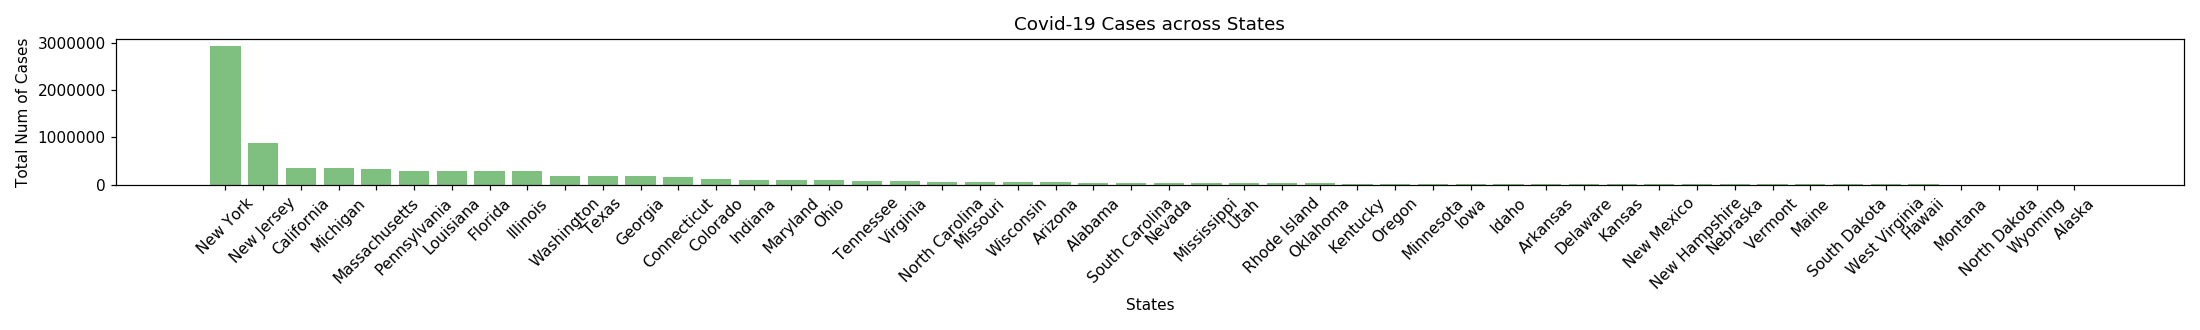

In [14]:
#visualising states with maximum Covid-19 Cases
x_axis = np.arange(len(sort_cases_df))
tick_locations = [value for value in x_axis]

# Create a list indicating where to write x labels and set figure size to adjust for space
plt.figure(figsize=(20,3))
plt.bar(x_axis,sort_cases_df["Total Covid-19 Cases"], color='g', alpha=0.5, align="center")
plt.xticks(tick_locations, sort_cases_df["State Name"], rotation=45)
plt.title("Covid-19 Cases across States")
plt.xlabel("States")
plt.ylabel("Total Num of Cases")
plt.grid(False)
plt.tight_layout()
plt.savefig("Charts/CovidCases.png")
plt.show()

In [17]:
sort_deaths_df=HeatMap_df.sort_values('Total Deaths Covid-19',ascending=False)
th_d=sort_deaths_df.loc[sort_deaths_df['Total Deaths Covid-19']>1001]
print(f"{th_d['State Name'].nunique()} states report ≥1000 deaths including{th_d['State Name'].unique()} as of {date}")
sort_deaths_df.head()

29 states report ≥1000 deaths including['New York' 'New Jersey' 'Michigan' 'Louisiana' 'California' 'Washington'
 'Massachusetts' 'Illinois' 'Connecticut' 'Georgia' 'Pennsylvania'
 'Florida' 'Indiana' 'Texas' 'Colorado' 'Ohio' 'Maryland' 'Wisconsin'
 'Virginia' 'Missouri' 'Arizona' 'Nevada' 'Tennessee' 'Oklahoma'
 'Kentucky' 'Alabama' 'Mississippi' 'South Carolina' 'North Carolina'] as of 04/18/20


,State,Latitude,Longitude,State Name,Date,Total Covid-19 Cases,Total Deaths Covid-19,Total Population,fips,"Mortality per 100,000",Case fatality Rate
31,NY,40.705626,-73.979680,New York,2020-04-16,2934070,115979,19798228.0,36,585.804952,3.952837
29,NJ,40.143006,-74.731116,New Jersey,2020-04-16,880217,28297,8960161.0,34,315.809057,3.214775
21,MI,44.943560,-86.415805,Michigan,2020-04-16,359758,18494,9925568.0,26,186.326868,5.140678
17,LA,30.973377,-91.429910,Louisiana,2020-04-16,293635,11983,4663461.0,22,256.955081,4.080917
4,CA,37.271875,-119.270415,California,2020-04-16,363603,9665,38982847.0,6,24.792956,2.658119


<IPython.core.display.Javascript object>


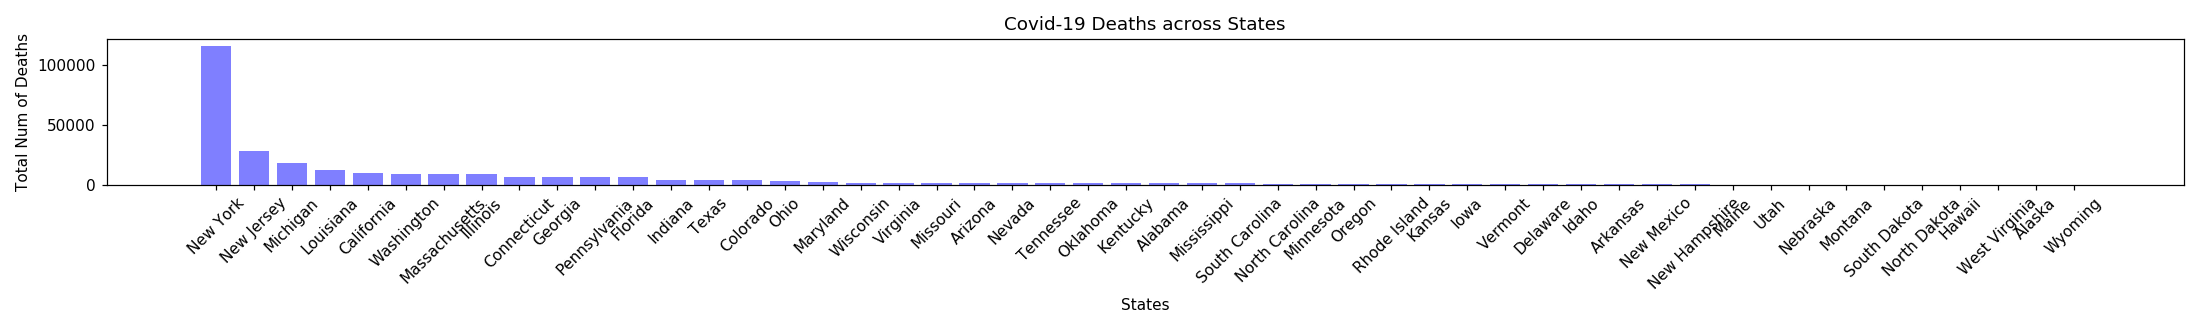

In [18]:
#visualising states with maximum cases
x_axis1 = np.arange(len(sort_deaths_df))
tick_locations1 = [value for value in x_axis1]

# Create a list indicating where to write x labels and set figure size to adjust for space
plt.figure(figsize=(20,3))
plt.bar(x_axis1,sort_deaths_df["Total Deaths Covid-19"], color='b', alpha=0.5,align="center")
plt.xticks(tick_locations1, sort_deaths_df["State Name"], rotation=45)
plt.title("Covid-19 Deaths across States")
plt.xlabel("States")
plt.ylabel("Total Num of Deaths")
plt.grid(False)
plt.tight_layout()
plt.savefig("Charts/CovidDeaths.png")
plt.show()

<IPython.core.display.Javascript object>


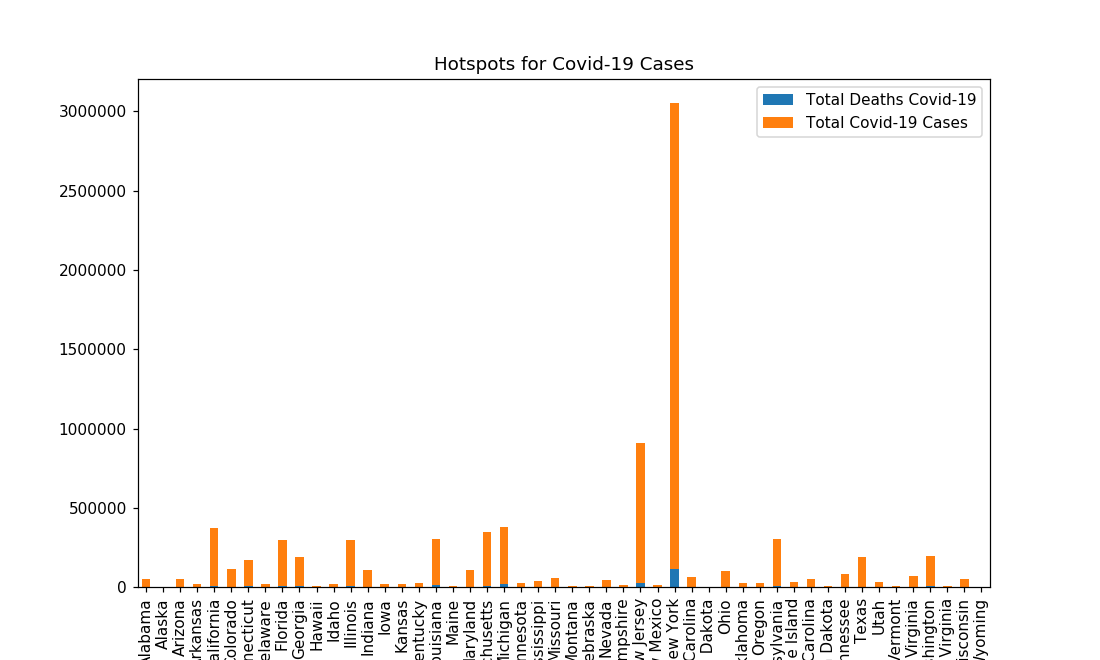

In [19]:
#StackedBar for Total Cases and Total Deaths

pivot_df=HeatMap_df[['State Name','Total Deaths Covid-19','Total Covid-19 Cases']]
pivot_df=pivot_df.set_index('State Name')

stack_fig= pivot_df[['Total Deaths Covid-19','Total Covid-19 Cases']].plot(kind="bar",figsize=(10,6), stacked=True)
plt.title("Hotspots for Covid-19 Cases")
plt.xlabel("States")
plt.grid(False)
plt.savefig("Charts/StackedBar.png")

In [22]:
#Covid 'Mortality per 100,000' per state in the USA

locations = HeatMap_df[["Latitude", "Longitude"]]

# Plot Heatmap
Covid = gmaps.figure()

impact=HeatMap_df['Mortality per 100,000']

# Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights=impact, dissipating=False, max_intensity=10,point_radius=1)

# Add layer
Covid.add_layer(heat_layer)

# Display figure
Covid



Figure(layout=FigureLayout(height='420px'))

# Dataset name: COVID-19 Hospital Needs and Death Projections
Source=http://www.healthdata.org/covid/data-downloads

*allbed_mean= Mean covid beds needed by day
*ICUbed_mean= Mean ICU covid beds needed by day
*InvVen_mean= Mean invasive ventilation needed by day
*deaths_mean= Mean daily covid deaths
*admis_mean= Mean hospital admissions by day
*newICU_mean= Mean number of new people going to the ICU by day
*totdea_mean= Mean cumulative covid deaths
*bedover_mean= covid all beds needed-(total bed capacity-average all bed usage)
*icuover_mean= covid ICU beds needed-(total ICU capacity-average ICU bed usage)

In [20]:
hospital_csv='Resources/Hospitalization_all_locs.csv'
hospital_df=pd.read_csv(hospital_csv)
hospital_df=hospital_df[['location_name','date','allbed_mean',
                         'ICUbed_mean','InvVen_mean',
                         'deaths_mean','admis_mean',
                         'newICU_mean','totdea_mean','bedover_mean',
                         'icuover_mean']]

hospital_df=hospital_df.rename(columns={'location_name':'State Name',"allbed_mean":'Covid beds',
                               'ICUbed_mean':'ICU_covid beds',"InvVen_mean":'Ventilators',
                                "deaths_mean":'Covid Deaths',"admis_mean":'Hospital Admits',
                                'newICU_mean':'New ICU Admits','totdea_mean':'Total Covid Deaths'})

As_day_forecast=hospital_df.loc[hospital_df['date']=='2020-04-27']

In [21]:
Readiness_df=pd.merge(As_day_forecast,Census_df,on='State Name')
Readiness_df=Readiness_df.set_index('State Name')
Mainland_readiness_df=Readiness_df.drop(['Alaska','Hawaii'])
Mainland_readiness_df=Mainland_readiness_df.sort_values('Covid beds',ascending=False)
Mainland_readiness_df

,date,Covid beds,ICU_covid beds,Ventilators,Covid Deaths,Hospital Admits,New ICU Admits,Total Covid Deaths,bedover_mean,icuover_mean,Total Population,fips,state_abbr,long_name,sumlev,region,division,state,region_name,division_name
State Name,,,,,,,,,,,,,,,,,,,,
Massachusetts,2020-04-27,8098.181267,1881.394215,1639.447482,201.294,1067.006539,249.611409,3357.660,3250.181267,1604.394215,6789319.0,25,MA,Massachusetts MA,40,1,1,25,Northeast,New England
Connecticut,2020-04-27,7191.155538,1493.758906,1256.037779,143.770,882.649305,177.628347,2524.978,5453.155538,1394.758906,3594478.0,9,CT,Connecticut CT,40,1,1,9,Northeast,New England
Florida,2020-04-27,6409.451438,1246.364720,1042.067167,112.245,827.171765,154.043708,2014.868,0.000000,0.000000,20278447.0,12,FL,Florida FL,40,3,5,12,South,South Atlantic
Georgia,2020-04-27,5487.793595,1053.453075,879.040662,94.153,712.115444,130.470115,1773.491,0.000000,464.453075,10201635.0,13,GA,Georgia GA,40,3,5,13,South,South Atlantic
Texas,2020-04-27,3875.037036,736.421549,614.478395,65.747,502.525866,91.525242,1157.795,0.000000,0.000000,27419612.0,48,TX,Texas TX,40,3,7,48,South,West South Central
California,2020-04-27,1927.567334,457.610103,334.444111,26.421,108.755213,21.754864,1504.699,0.000000,0.000000,38982847.0,6,CA,California CA,40,4,9,6,West,Pacific
Missouri,2020-04-27,1822.693591,368.628372,310.987833,35.600,224.911786,44.833649,589.237,0.000000,0.000000,6075300.0,29,MO,Missouri MO,40,2,4,29,Midwest,West North Central
Pennsylvania,2020-04-27,1739.601999,415.991255,321.424761,33.476,126.412307,27.149802,1321.627,0.000000,0.000000,12790505.0,42,PA,Pennsylvania PA,40,1,2,42,Northeast,Middle Atlantic
New York,2020-04-27,1516.858500,536.227500,384.676000,34.958,24.161500,9.244500,13386.092,0.000000,0.000000,19798228.0,36,NY,New York NY,40,1,2,36,Northeast,Middle Atlantic


In [23]:
shapefile='data/cb_2018_us_state_500k.shp'
gdf = gpd.read_file(shapefile)[['NAME','geometry']]
gdf.columns=['State Name','geometry']

#Merging geodataframe and dataframe 
Covid_Visual = gdf.merge(Mainland_readiness_df, left_on = 'State Name', right_on = 'State Name')

<IPython.core.display.Javascript object>


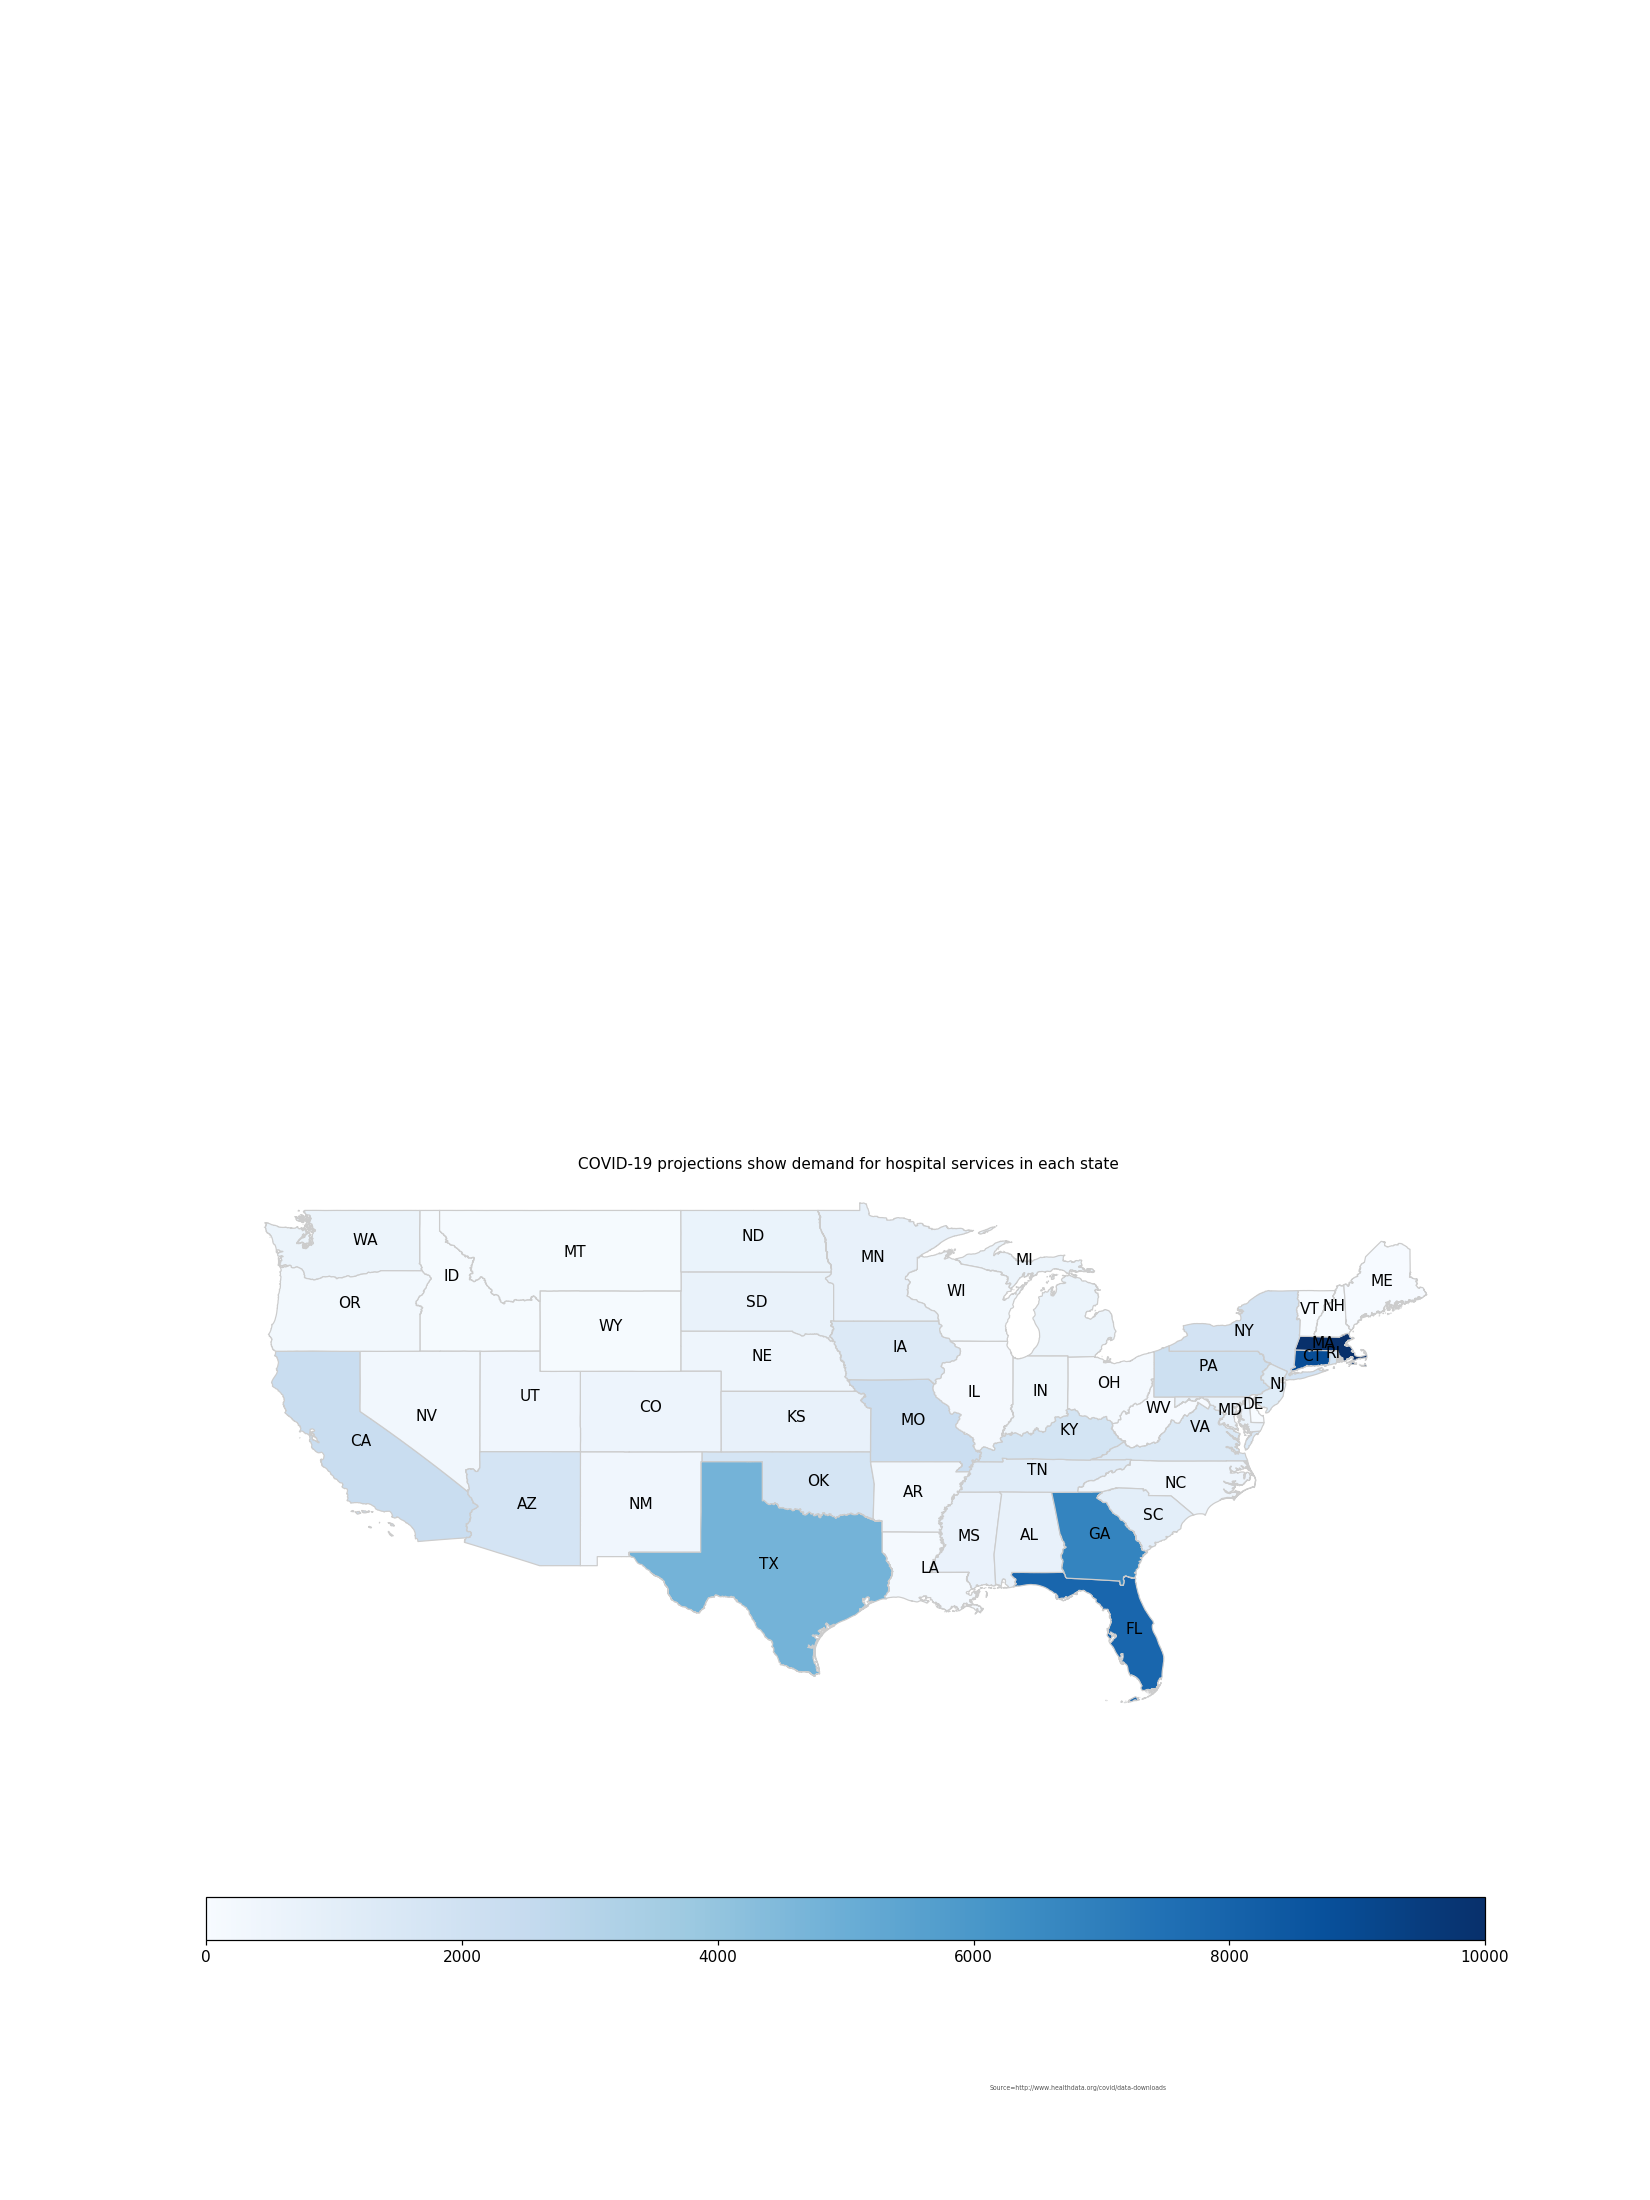

In [25]:
#value to be visualised
variable='Covid beds'

# set the range for the choropleth values
vmin, vmax = 0, 10000

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(15, 20))

# remove the axis
ax.axis('off')

# add a title and annotation
ax.set_title(' COVID-19 projections show demand for hospital services in each state', fontdict={'fontsize': '10'})
ax.annotate('Source=http://www.healthdata.org/covid/data-downloads', xy=(0.6, .05), xycoords='figure fraction', fontsize=4, color='#555555')

# Create colorbar legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))

# empty array for the data range
sm.set_array([]) 

# create map
Covid_Visual.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')

# Add Labels
Covid_Visual['coords'] = Covid_Visual['geometry'].apply(lambda x: x.representative_point().coords[:])
Covid_Visual['coords'] = [coords[0] for coords in Covid_Visual['coords']]

for idx, row in Covid_Visual.iterrows():
    plt.annotate(s=row['state_abbr'], xy=row['coords'],horizontalalignment='center')
            
fig.colorbar(sm, orientation="horizontal", fraction=0.036, pad=0.1, aspect = 30)

fig.savefig("Charts/CovidBeds.png", dpi=300)

#IHME’s COVID-19 projections show demand for hospital services in each state.